<span style="font-size:24px; font-weight:bold; color:black;">Step 1: Data Understanding</span>

In [165]:
# Import necessary libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import numpy as np
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import xgboost as xgb
from sklearn.model_selection import GridSearchCV
from xgboost import plot_importance
from geopy.distance import geodesic
from sklearn.cluster import KMeans

In [185]:
# Load dataset
data = pd.read_csv('kc_house_data.csv')

# Overview of the dataset
print("Dataset Shape:", data.shape)
print("Dataset Columns:", data.columns.tolist())
print("Preview of Data:\n", data.head())

# Summary statistics
print("\nSummary Statistics:\n", data.describe())

# Check for missing values
print("\nMissing Values:\n", data.isnull().sum())


Dataset Shape: (21613, 21)
Dataset Columns: ['id', 'date', 'price', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors', 'waterfront', 'view', 'condition', 'grade', 'sqft_above', 'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode', 'lat', 'long', 'sqft_living15', 'sqft_lot15']
Preview of Data:
            id             date     price  bedrooms  bathrooms  sqft_living  \
0  7129300520  20141013T000000  221900.0         3       1.00         1180   
1  6414100192  20141209T000000  538000.0         3       2.25         2570   
2  5631500400  20150225T000000  180000.0         2       1.00          770   
3  2487200875  20141209T000000  604000.0         4       3.00         1960   
4  1954400510  20150218T000000  510000.0         3       2.00         1680   

   sqft_lot  floors  waterfront  view  ...  grade  sqft_above  sqft_basement  \
0      5650     1.0           0     0  ...      7        1180              0   
1      7242     2.0           0     0  ...      7        2170  

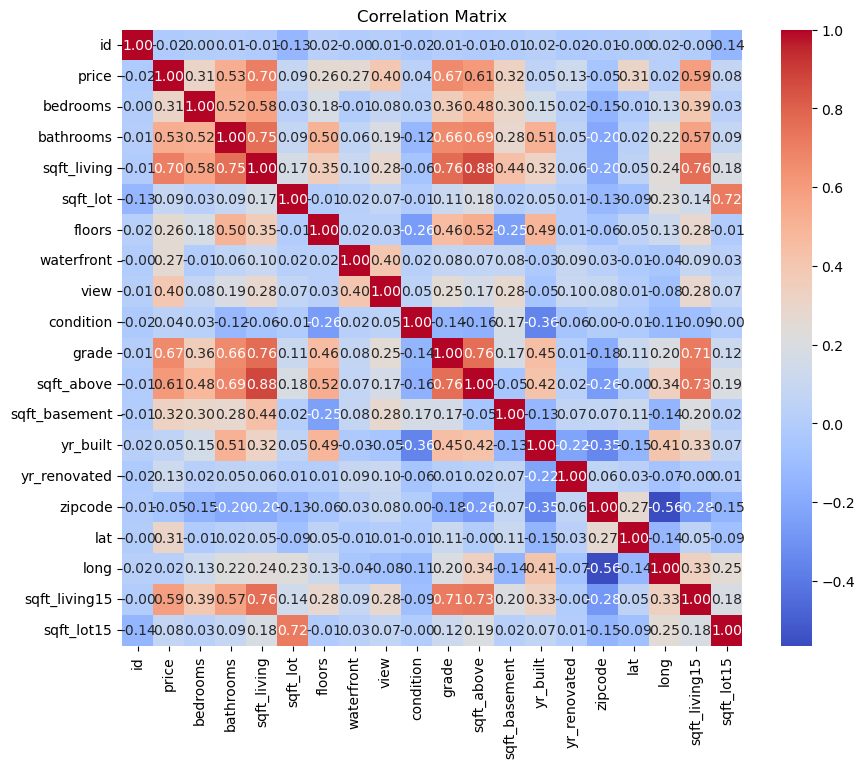

In [187]:
# Visualize correlations with the target variable 'price'

# Drop non-numeric columns to compute correlations
numeric_data = data.select_dtypes(include=['number'])
correlation_matrix = numeric_data.corr()
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap="coolwarm")
plt.title("Correlation Matrix")
correlation_plot_path = 'house_correlation_matrix.png'
plt.savefig(correlation_plot_path)
plt.show()

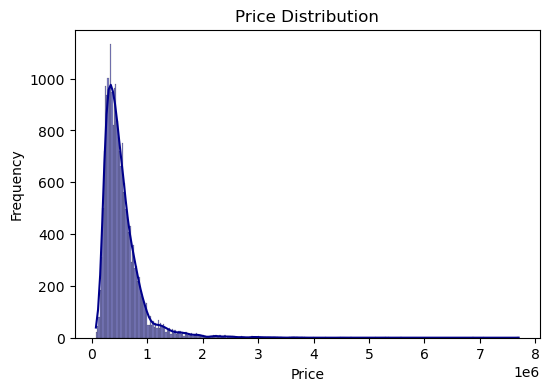

In [189]:
# Visualize price distribution
plt.figure(figsize=(6, 4))
sns.histplot(data['price'], kde=True, color='darkblue')
plt.title("Price Distribution")
plt.xlabel("Price")
plt.ylabel("Frequency")
price_distribution_path = 'house_price_distribution.png'
plt.savefig(price_distribution_path)
plt.show()

<span style="font-size:24px; font-weight:bold; color:black;">Step 2: Data Preparation</span>

In [135]:
# Drop non-informative columns
data = data.drop(columns=['id', 'date'])

# Apply log transformation to `price` to reduce skewness
data['price'] = np.log1p(data['price']) 

# Feature Engineering
# Create 'house_age' from 'yr_built'
data['house_age'] = 2024 - data['yr_built'] 

# Create 'recent_renovation' indicator from 'yr_renovated'
data['recent_renovation'] = data['yr_renovated'].apply(lambda x: 1 if x > 2010 else 0)

# Drop original 'yr_built' and 'yr_renovated' as they are now redundant
data = data.drop(columns=['yr_built', 'yr_renovated'])

# Define numeric columns for scaling (exclude target 'price')
numeric_features = data.select_dtypes(include=['number']).columns.tolist()
numeric_features.remove('price')  # Exclude the target variable

# Scaling numeric features
scaler = MinMaxScaler()
data[numeric_features] = scaler.fit_transform(data[numeric_features])

# Splitting data into features and target
X = data.drop(columns=['price'])
y = data['price']

# Split data into training, validation, and test sets (70-15-15 split)
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Display shapes of each split
print("Training Set Shape:", X_train.shape)
print("Validation Set Shape:", X_val.shape)
print("Test Set Shape:", X_test.shape)

Training Set Shape: (15129, 18)
Validation Set Shape: (3242, 18)
Test Set Shape: (3242, 18)


<span style="font-size:24px; font-weight:bold; color:black;">Step 3: Modeling and Testing on Validation Set</span>

In [137]:
# Initialize models
models = {
    "Multiple Linear Regression": LinearRegression(),
    "Ridge Regression": Ridge(alpha=1.0), 
    "Lasso Regression": Lasso(alpha=0.1), 
    "Random Forest": RandomForestRegressor(random_state=42),
    "XGBoost": XGBRegressor(random_state=42)
}

# Dictionary to store model performance results
results = {}

# Train and evaluate each model
for name, model in models.items():
    # Train the model on the training data
    model.fit(X_train, y_train)
    
    # Predict on the validation set
    y_val_pred = model.predict(X_val)
    
    # Calculate evaluation metrics
    r2 = r2_score(y_val, y_val_pred)
    rmse = np.sqrt(mean_squared_error(y_val, y_val_pred))
    mae = mean_absolute_error(y_val, y_val_pred)
    
    # Store the results
    results[name] = {"R²": r2, "RMSE": rmse, "MAE": mae}
    print(f"{name}: R² = {r2:.2f}, RMSE = {rmse:.2f}, MAE = {mae:.2f}")

# Identify the best model based on R² on the validation set
best_model_name = max(results, key=lambda k: results[k]["R²"])
best_model = models[best_model_name]
print(f"\nBest Model: {best_model_name}")


Multiple Linear Regression: R² = 0.76, RMSE = 0.26, MAE = 0.20
Ridge Regression: R² = 0.76, RMSE = 0.26, MAE = 0.20
Lasso Regression: R² = -0.00, RMSE = 0.53, MAE = 0.41
Random Forest: R² = 0.88, RMSE = 0.18, MAE = 0.13
XGBoost: R² = 0.89, RMSE = 0.17, MAE = 0.12

Best Model: XGBoost


<span style="font-size:24px; font-weight:bold; color:black;">Step 4: Model Improvement : Hyperparameter Tuning</span>

In [139]:
# Define the parameter grid
param_grid = {
    'learning_rate': [0.01, 0.1, 0.2],
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 5, 7],
    'min_child_weight': [1, 3, 5],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0]
}

# Initialize XGBoost regressor
xgb = XGBRegressor(random_state=42)

# Set up GridSearchCV
grid_search = GridSearchCV(estimator=xgb, param_grid=param_grid, 
                           scoring='r2', cv=3, verbose=2, n_jobs=-1)

# Perform the grid search on the training set
grid_search.fit(X_train, y_train)

# Retrieve the best parameters and best model
best_params = grid_search.best_params_
best_xgb_model = grid_search.best_estimator_

print("Best Parameters:", best_params)
print("Best R² Score on training Set:", grid_search.best_score_)


Fitting 3 folds for each of 324 candidates, totalling 972 fits
Best Parameters: {'colsample_bytree': 0.8, 'learning_rate': 0.1, 'max_depth': 5, 'min_child_weight': 3, 'n_estimators': 300, 'subsample': 0.8}
Best R² Score on training Set: 0.8979585570033565


<span style="font-size:24px; font-weight:bold; color:black;">Step 5: Validate Tuned model on validation set and Test set  </span>

In [141]:
# Validate the tuned model on the validation set
y_val_pred = best_xgb_model.predict(X_val)

# Compute validation metrics
val_r2 = r2_score(y_val, y_val_pred)
val_rmse = np.sqrt(mean_squared_error(y_val, y_val_pred))
val_mae = mean_absolute_error(y_val, y_val_pred)

print("Validation Set Performance of Tuned Model:")
print(f"R²: {val_r2:.2f}")
print(f"RMSE: {val_rmse:.2f}")
print(f"MAE: {val_mae:.2f}")

# evaluation on the test set
y_test_pred = best_xgb_model.predict(X_test)

# Compute test metrics
test_r2 = r2_score(y_test, y_test_pred)
test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
test_mae = mean_absolute_error(y_test, y_test_pred)

print("\nFinal Test Set Performance of Tuned Model:")
print(f"R²: {test_r2:.2f}")
print(f"RMSE: {test_rmse:.2f}")
print(f"MAE: {test_mae:.2f}")


Validation Set Performance of Tuned Model:
R²: 0.90
RMSE: 0.17
MAE: 0.12

Final Test Set Performance of Tuned Model:
R²: 0.91
RMSE: 0.16
MAE: 0.12


<span style="font-size:24px; font-weight:bold; color:black;">Step 6: Evaluation of Prediction</span>

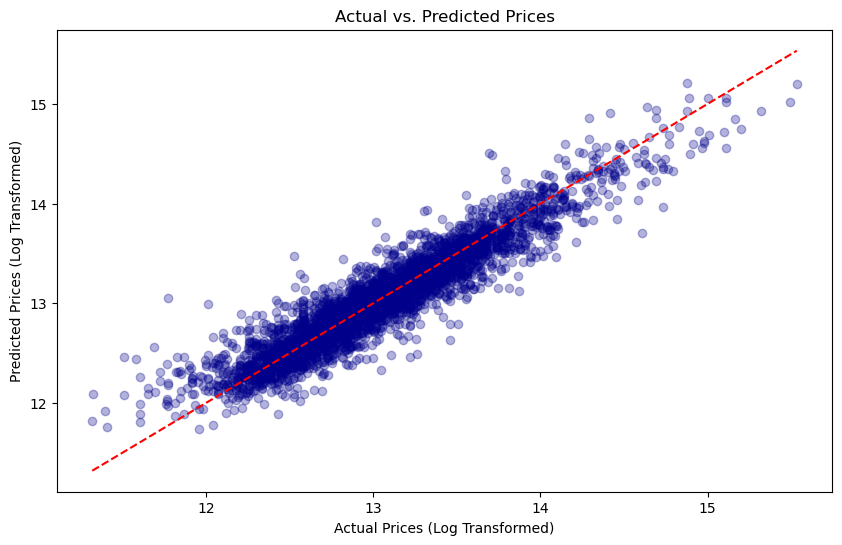

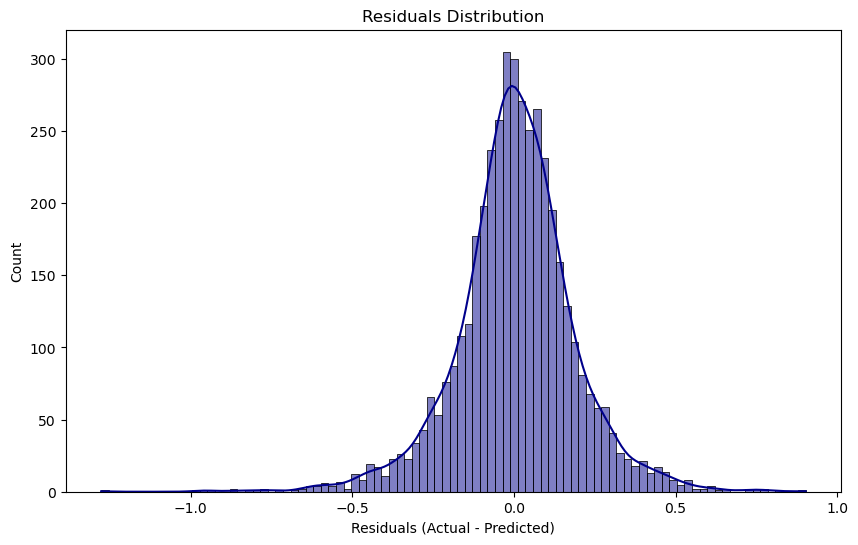

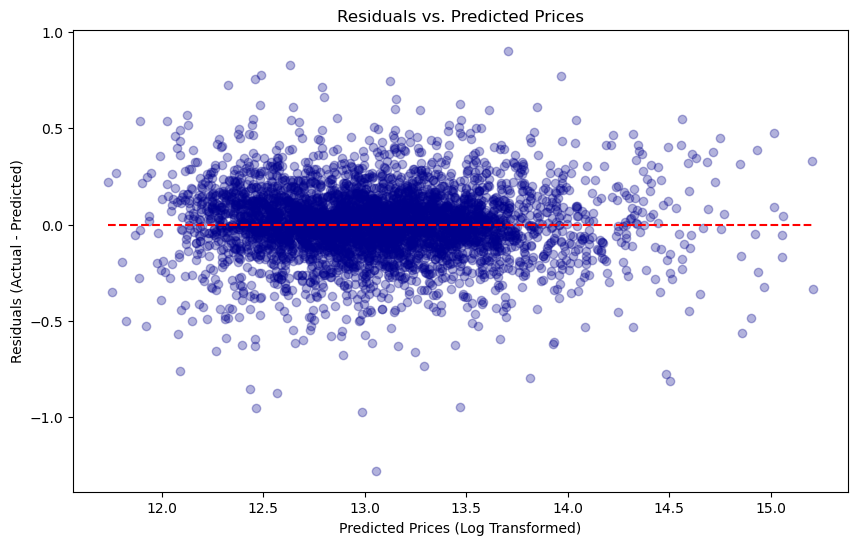

In [169]:
# Calculate residuals
residuals = y_test - y_test_pred

# Actual vs Predicted Plot
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_test_pred, alpha=0.3,color='darkblue')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--') 
plt.xlabel("Actual Prices (Log Transformed)")
plt.ylabel("Predicted Prices (Log Transformed)")
plt.title("Actual vs. Predicted Prices")
actual_vs_predicted_path = 'house_actual_vs_predicted_prices.png'
plt.savefig(actual_vs_predicted_path)
plt.show()

# Residual Distribution Plot
plt.figure(figsize=(10, 6))
sns.histplot(residuals, kde=True, color='darkblue')
plt.xlabel("Residuals (Actual - Predicted)")
plt.title("Residuals Distribution")
residual_distribution_path = 'house_residual_distribution.png'
plt.savefig(residual_distribution_path)
plt.show()

# Residuals vs Predicted Plot
plt.figure(figsize=(10, 6))
plt.scatter(y_test_pred, residuals, alpha=0.3, color='darkblue')
plt.hlines(0, xmin=y_test_pred.min(), xmax=y_test_pred.max(), colors='r', linestyles='--')
plt.xlabel("Predicted Prices (Log Transformed)")
plt.ylabel("Residuals (Actual - Predicted)")
plt.title("Residuals vs. Predicted Prices")
residuals_vs_predicted_path = 'house_residuals_vs_predicted_prices.png'
plt.savefig(residuals_vs_predicted_path)
plt.show()

<span style="font-size:20px; font-weight:bold; color:black;">6.1 Feature Importance</span>

<Figure size 1000x600 with 0 Axes>

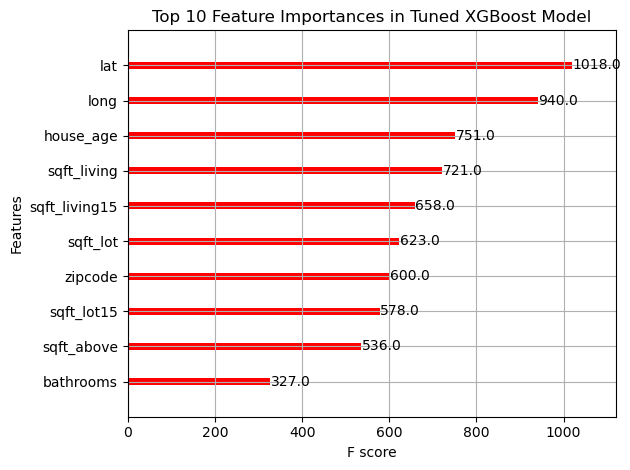

In [171]:
# Plot feature importances
plt.figure(figsize=(10, 6))
plot_importance(best_xgb_model, max_num_features=10, importance_type='weight', color='red')  
plt.title("Top 10 Feature Importances in Tuned XGBoost Model")
plt.xlabel("F score")
plt.ylabel("Features")
plt.tight_layout()
feature_importance_path = 'house_feature_importance.png'
plt.savefig(feature_importance_path)
plt.show()

<span style="font-size:20px; font-weight:bold; color:black;">6.2 : Residuals by Feature</span>

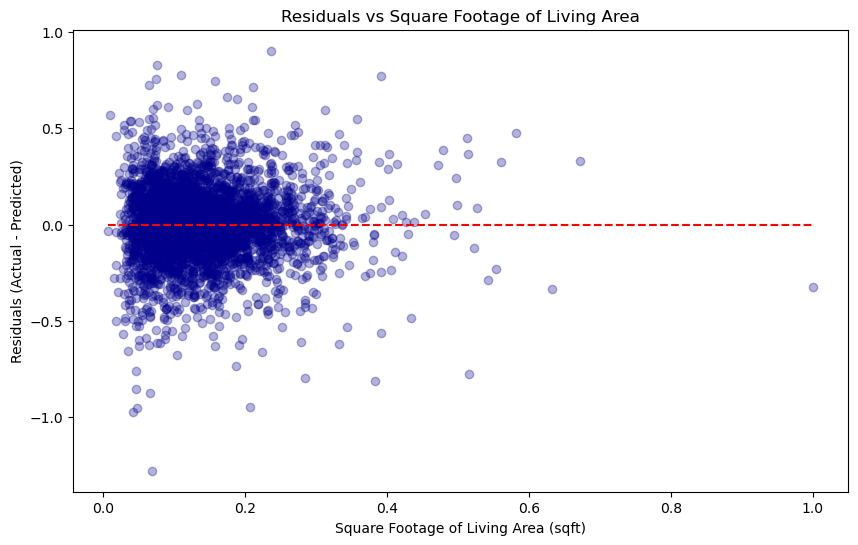

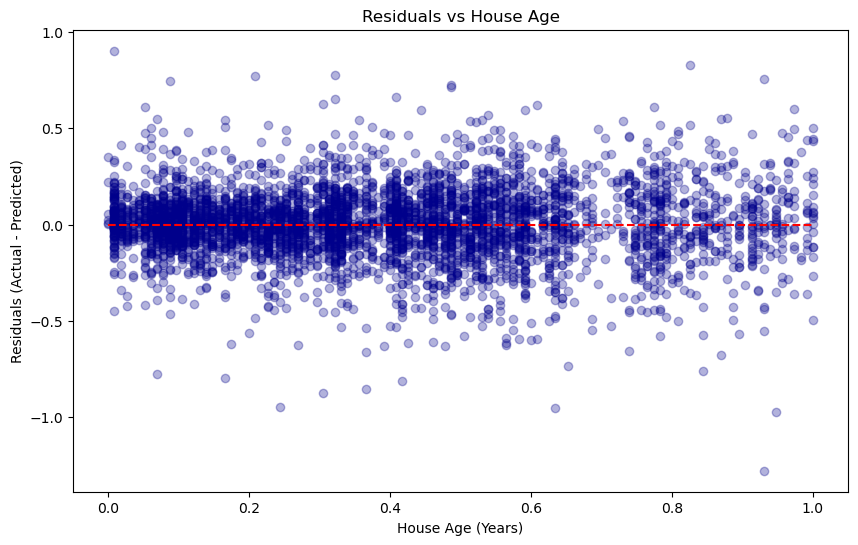

In [173]:
# Plot Residuals vs Square Footage of Living Area
plt.figure(figsize=(10, 6))
plt.scatter(X_test['sqft_living'], residuals, alpha=0.3, color='darkblue')
plt.hlines(0, xmin=X_test['sqft_living'].min(), xmax=X_test['sqft_living'].max(), colors='r', linestyles='--')
plt.xlabel("Square Footage of Living Area (sqft)")
plt.ylabel("Residuals (Actual - Predicted)")
plt.title("Residuals vs Square Footage of Living Area")
residuals_vs_sqft_living_path = 'house_residuals_vs_sqft_living.png'
plt.savefig(residuals_vs_sqft_living_path)
plt.show()

# Plot Residuals vs House Age
plt.figure(figsize=(10, 6))
plt.scatter(X_test['house_age'], residuals, alpha=0.3, color='darkblue')
plt.hlines(0, xmin=X_test['house_age'].min(), xmax=X_test['house_age'].max(), colors='r', linestyles='--')
plt.xlabel("House Age (Years)")
plt.ylabel("Residuals (Actual - Predicted)")
plt.title("Residuals vs House Age")
residuals_vs_house_age_path = 'house_residuals_vs_house_age.png'
plt.savefig(residuals_vs_house_age_path)
plt.show()

<span style="font-size:20px; font-weight:bold; color:black;">6.3 : Error Analysis by Price Range</span>

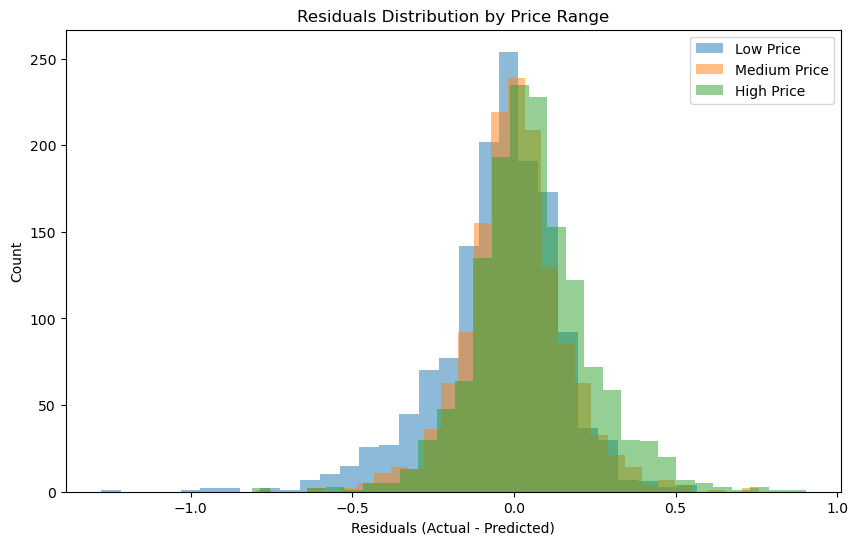

In [177]:
# Define price ranges
low_price = y_test < np.percentile(y_test, 33)
medium_price = (y_test >= np.percentile(y_test, 33)) & (y_test < np.percentile(y_test, 66))
high_price = y_test >= np.percentile(y_test, 66)

# Calculate residuals for each price group
residuals_low = residuals[low_price]
residuals_medium = residuals[medium_price]
residuals_high = residuals[high_price]

# Plot Residuals by Price Range
plt.figure(figsize=(10, 6))
plt.hist(residuals_low, bins=30, alpha=0.5, label="Low Price")
plt.hist(residuals_medium, bins=30, alpha=0.5, label="Medium Price")
plt.hist(residuals_high, bins=30, alpha=0.5, label="High Price")
plt.legend()
plt.title("Residuals Distribution by Price Range")
plt.xlabel("Residuals (Actual - Predicted)")
plt.ylabel("Count")
price_range_residuals_path = 'house_residuals_by_price_range.png'
plt.savefig(price_range_residuals_path)
plt.show()

<span style="font-size:24px; font-weight:bold; color:black;">Step 7 : Improvement for High Price Range- Feature Engineering</span>

In [151]:
pip install geopy


Note: you may need to restart the kernel to use updated packages.


In [153]:
#Luxury Amenities (Creating Binary Features)
# Adding binary features for luxury amenities
data['has_pool'] = data['waterfront'].apply(lambda x: 1 if x == 1 else 0)  
data['has_basement'] = data['sqft_basement'].apply(lambda x: 1 if x > 0 else 0)
data['has_view'] = data['view'].apply(lambda x: 1 if x > 0 else 0)

#Proximity to High-Demand Areas (Using Latitude and Longitude)
#Using a central point (downtown Seattle)
central_location = (47.6097, -122.3331)  # Latitude and longitude for downtown Seattle
# Function to compute distance to central location
def compute_distance(row):
    property_location = (row['lat'], row['long'])
    return geodesic(property_location, central_location).km
# Adding the distance feature
data['distance_to_center'] = data.apply(compute_distance, axis=1)


# Neighborhood-Level Features (Using Zipcode)
# Clustering properties by latitude and longitude to create neighborhood clusters
coords = data[['lat', 'long']].values
kmeans = KMeans(n_clusters=10, random_state=42) 
data['neighborhood_cluster'] = kmeans.fit_predict(coords)

# encode 'zipcode' as a categorical feature
data['zipcode'] = data['zipcode'].astype('category').cat.codes


<span style="font-size:20px; font-weight:bold; color:black;"> 7.1 : Re-Train Model with New Features and performance evaluation </span>

In [159]:
# Define the XGBoost model
xgb_model = XGBRegressor(random_state=42)

# Select the relevant features including newly engineered ones
features = ['sqft_living', 'sqft_lot', 'bedrooms', 'bathrooms', 'house_age', 'recent_renovation', 
            'lat', 'long', 'distance_to_center', 'has_pool', 'has_basement', 'has_view', 'neighborhood_cluster', 'zipcode']

# Prepare the data
X_high_price = data[features]
y_high_price = data['price'] 
X_test_high = data[features]
y_test_high = data['price']
# Split the data again for training and validation
X_train_high, X_val_high, y_train_high, y_val_high = train_test_split(X_high_price, y_high_price, test_size=0.2, random_state=42)

# Re-train the XGBoost model with new features
xgb_model.fit(X_train_high, y_train_high)

# Predict and evaluate the model on validation set
y_val_pred_high = xgb_model.predict(X_val_high)
r2_high = r2_score(y_val_high, y_val_pred_high)
rmse_high = np.sqrt(mean_squared_error(y_val_high, y_val_pred_high))
mae_high = mean_absolute_error(y_val_high, y_val_pred_high)

# Output the updated evaluation metrics
print(f"Updated Model Performance on feature engineering- Validation Set:")
print(f"R²: {r2_high:.2f}")
print(f"RMSE: {rmse_high:.2f}")
print(f"MAE: {mae_high:.2f}")

# Predict and evaluate the model on test set
y_test_pred_high = xgb_model.predict(X_test_high)
# Evaluate the model's performance on the test set
r2_test = r2_score(y_test_high, y_test_pred_high)
rmse_test = np.sqrt(mean_squared_error(y_test_high, y_test_pred_high))
mae_test = mean_absolute_error(y_test_high, y_test_pred_high)

# Output the performance on the test set
print(f"Final Model Performance on feature engineering- Test Set:")
print(f"R²: {r2_test:.2f}")
print(f"RMSE: {rmse_test:.2f}")
print(f"MAE: {mae_test:.2f}")


Updated Model Performance on feature engineering- Validation Set:
R²: 0.89
RMSE: 0.18
MAE: 0.13
Final Model Performance on feature engineering- Test Set:
R²: 0.93
RMSE: 0.14
MAE: 0.10


<span style="font-size:20px; font-weight:bold; color:black;">7.2 : Error Analysis by Price Range</span>

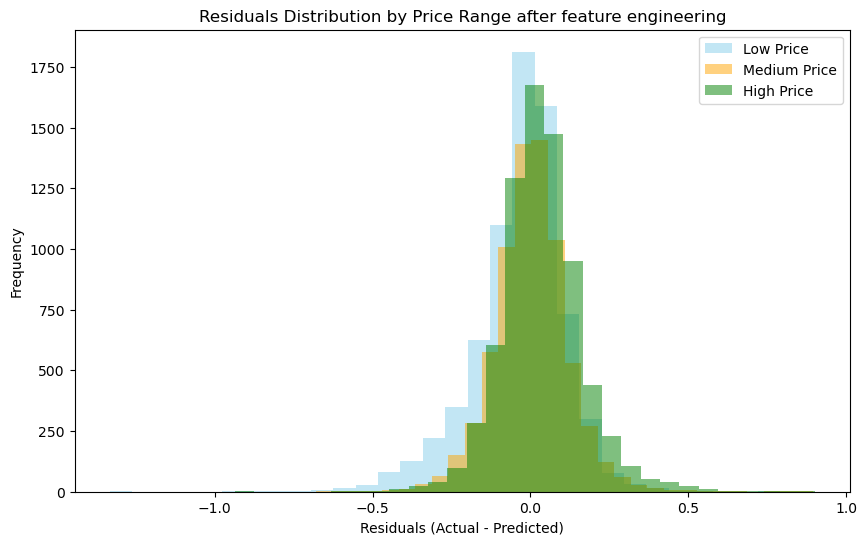

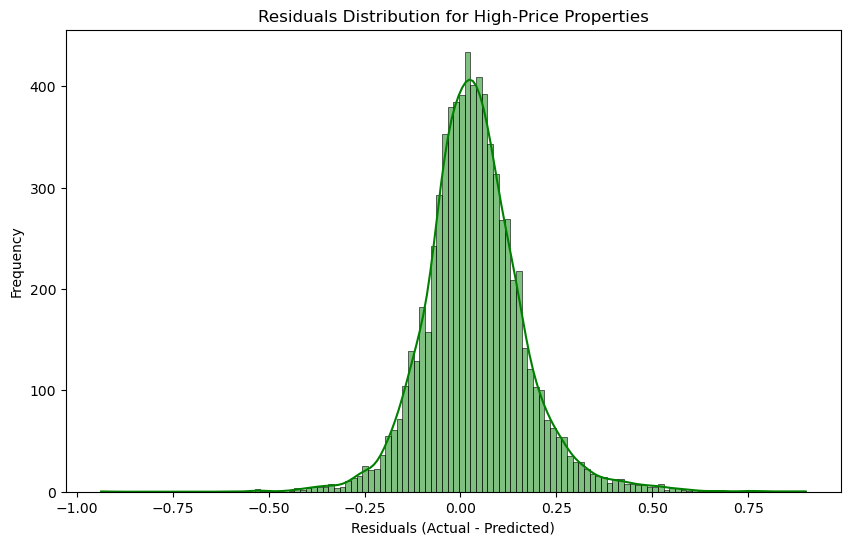

In [181]:
# Calculate residuals (Actual - Predicted) for all test set
residuals_all = y_test_high - y_test_pred_high

# Define price ranges based on percentiles
low_price = y_test_high < np.percentile(y_test_high, 33)  # Low price: Bottom 33%
medium_price = (y_test_high >= np.percentile(y_test_high, 33)) & (y_test_high < np.percentile(y_test_high, 66))  # Middle 33%
high_price = y_test_high >= np.percentile(y_test_high, 66)  # High price: Top 33%

# Get the residuals for each price range
residuals_low = residuals_all[low_price]
residuals_medium = residuals_all[medium_price]
residuals_high = residuals_all[high_price]

# Plot Residuals Distribution for Low, Medium, and High Price Properties
plt.figure(figsize=(10, 6))
plt.hist(residuals_low, bins=30, alpha=0.5, label="Low Price", color='skyblue')
plt.hist(residuals_medium, bins=30, alpha=0.5, label="Medium Price", color='orange')
plt.hist(residuals_high, bins=30, alpha=0.5, label="High Price", color='green')
plt.legend()
plt.title("Residuals Distribution by Price Range after feature engineering")
plt.xlabel("Residuals (Actual - Predicted)")
plt.ylabel("Frequency")
residuals_by_price_range_path = 'residuals_by_price_range_high.png'
plt.savefig(residuals_by_price_range_path)
plt.show()

# Plotting Residuals for High-Price Properties (Specifically)
plt.figure(figsize=(10, 6))
sns.histplot(residuals_high, kde=True, color='green')
plt.title("Residuals Distribution for High-Price Properties")
plt.xlabel("Residuals (Actual - Predicted)")
plt.ylabel("Frequency")
high_price_residuals_path = 'high_price_residuals.png'
plt.savefig(high_price_residuals_path)
plt.show()

<span style="font-size:24px; font-weight:bold; color:black;">Step 8: Final Evaluation of Prediction</span>

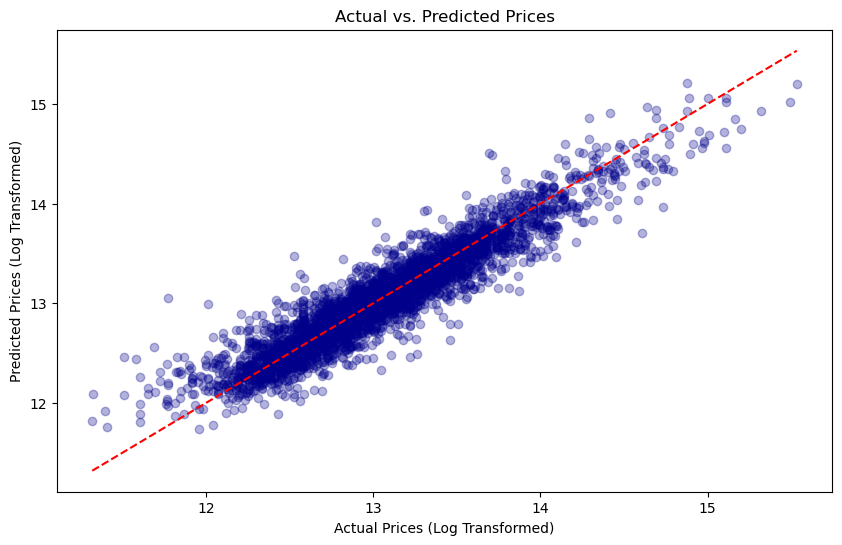

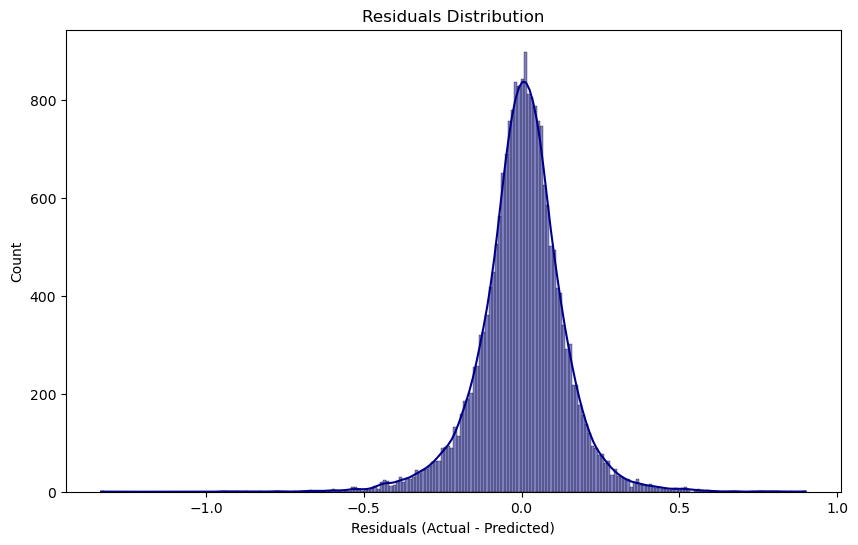

In [183]:
# Calculate residuals
residuals = y_test_high - y_test_pred_high

# Actual vs Predicted Plot
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_test_pred, alpha=0.3, color='darkblue')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')  
plt.xlabel("Actual Prices (Log Transformed)")
plt.ylabel("Predicted Prices (Log Transformed)")
plt.title("Actual vs. Predicted Prices")
actual_vs_predicted_path = 'fin_house_actual_vs_predicted_prices.png'
plt.savefig(actual_vs_predicted_path)
plt.show()

# Residual Distribution Plot
plt.figure(figsize=(10, 6))
sns.histplot(residuals, kde=True, color='darkblue')
plt.xlabel("Residuals (Actual - Predicted)")
plt.title("Residuals Distribution")
residual_distribution_path = 'fin_house_residual_distribution.png'
plt.savefig(residual_distribution_path)
plt.show()